Семинар 3: DARTS и QLoRA
===============================

**Материал взят из [Источника 1](https://github.com/diff7/Efficient-DL-models-Seminars/blob/41d5d25f0a3291ed72e40d121bf3f68b4f0c32a5/seminar_nas/darts.ipynb) [Источника 2](https://pytorch.org/torchtune/stable/tutorials/qlora_finetune.html)**

In [1]:
import random

import numpy as np

import torch

In [2]:
def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    
set_global_seed(42)

# DARTS

In [3]:
# !pip install nni
# !pip install pytorch-lightning


# Поиск в пространстве поиска DARTS

Ниже мы:

1) Воспользуемся готовыми пространствами моделей из NNI

2) Используем one-shot стратегиями открытия

3) Зададим оценщики для получения лучших результатов

В конце мы обучим модель для CIFAR-10 с качеством .


## Использование преднайденной DARTS модель

Пойдем аналогично [the beginner tutorial of PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) и для начала загрузим датасет.


In [4]:
from torchvision import transforms

In [5]:
IMAGE_NET_MEAN = np.array([0.49139968, 0.48215827, 0.44653124])
IMAGE_NET_STD  = np.array([0.24703233, 0.24348505, 0.26158768])

def inverse_data(data):
    
    img = data * IMAGE_NET_STD[:, None, None] + IMAGE_NET_MEAN[:, None, None]
    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)
    
    return img


def prepare_transform():

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGE_NET_MEAN,
                             std=IMAGE_NET_STD)
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGE_NET_MEAN,
                             std=IMAGE_NET_STD)
    ])


    return train_transform, test_transform

In [6]:
transform_train, transform_valid = prepare_transform()

In [7]:
import nni
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
from nni.nas.evaluator.pytorch import DataLoader

valid_data = nni.trace(CIFAR10)(root='./data', train=False, download=True, transform=transform_valid)
valid_loader = DataLoader(valid_data, batch_size=256, num_workers=6)

/home/alexandr/miniconda3/envs/ml/lib/python3.9/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/alexandr/miniconda3/envs/ml/lib/python3.9/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Files already downloaded and verified


NNI предлагает множество встроенных модельных пространств, а *предварительно найденных моделей* в `</nas/space_hub>`, которые создаются в большинстве популярных статей про NAS.

Предварительно обученная модель -- это сохраненная сеть, которая была предварительно обучена на большом наборе данных, например CIFAR-10 или ImageNet.


Вы можете легко загрузить эти модели в качестве начальной иницилизации точки, проверить их производительность и при необходимости зайфатюнить их.

В этом руководстве мы выбираем модель из пространства поиска `DARTS`, которая изначально обучена на нашем целевом наборе данных CIFAR-10, чтобы избежать утомительных шагов по настройке.


Мы рекомендуем прочитать [этот учебник по файтюнингу для задачи обнаружения объектов](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html), если вы хотите узнать, как обычно выполняется файтюнинг в PyTorch.


## Использование модельного пространства DARTS 

Модельное пространство, представленное в `DARTS`, взято из статьи [NASNet](https://arxiv.org/abs/1707.07012),
где полная модель строится путем многократного наращивания одного вычислительного блока (называемого **cell**).
В сети существует два типа `cell`. Первый тип называется *normal cell*, а второй - *reduction cell*.
Ключевое различие между normal и reduction cell заключается в том, что reduction ce;; уменьшает дискретизацию входной карты признаков, и уменьшает ее разрешение. Normal и reduction cell укладываются поочередно, как показано на следующем рисунке.

<img src="https://nni.readthedocs.io/en/stable/_images/nasnet_cell_stack.png">


`Cell` принимает в качестве входных данных выходы двух предыдущих ячеек и содержит коллекцию `nodes`.
Каждая `node` принимает два предыдущих node в пределах одной `cell` (или два входа `cell`) и применяет к каждому входу `operator` (например, свертку или max-pooling), потом суммирует выходы `operator` в качестве выхода `node`.
Выход `cell` - это конкатенация всех `node`, которые никогда не используются в качестве входов другого `node`.
Для получения более подробной информации желающие могут прочитать [NDS](https://arxiv.org/pdf/1905.13214.pdf) или [ENAS](https://arxiv.org/abs/1802.03268).

Пример ячеек показан на следующем рисунке.

<img src="https://nni.readthedocs.io/en/stable/_images/nasnet_cell.png">.


Пространство поиска, предложенное в статье `DARTS`, содержит две модификации исходного пространства
в [NASNet](https://arxiv.org/abs/1707.07012).

Во-первых, число кандидатов в `operator` было сокращено до семи:

- Max pooling 3x3
- Average pooling 3x3
- Skip connect (Identity)
- Separable convolution 3x3
- Separable convolution 5x5
- Dilated convolution 3x3
- Dilated convolution 5x5

Во-вторых, выход `cell` - это конкатинация **всех nodes внутри cell**.

Поскольку пространство поиска основано на ячейках, после того как normal и reduction cell определены, мы можем складывать их неограниченное количество раз.
Чтобы снизить стоимость поиска, обычно уменьшают количество фильтров (т.е. каналов) и количество сложенных ячеек
на этапе поиска, и увеличивать их обратно при обучении окончательной искомой архитектуры.

**Примечание**

`DARTS` - одна из тех работ, которые являются инновационными как в пространстве поиска, так и в стратегии поиска.
  


В этом ноутбуке мы выполним поиск в **пространстве моделей**, предоставленном DARTS, с помощью **стратегии поиска**, предложенной DARTS.
  
Мы называем их  *DARTS model space* (``DartsSpace``) и *DARTS strategy* (``DartsStrategy``) соответственно.
  
 
В следующем примере мы инициализируем класс:`~nni.nas.hub.pytorch.DARTS`
пространство модели с 16 исходными фильтрами и 8 `cell`.
Сеть предназначена для набора данных CIFAR-10 с разрешением входных данных 32x32.

Класс:`~nni.nas.hub.pytorch.Пространство моделей DARTS представлено в документе:"model space hub </nas/space_hub>`,
где мы поддерживаем несколько популярных пространств моделей для подключения и воспроизведения.



Пространство модели здесь может быть заменено любым пространством, предусмотренным в hub,
или даже пространствами, созданными с нуля.

In [8]:
from nni.nas.hub.pytorch import DARTS as DartsSpace

model_space = DartsSpace(
    width=10,           # the initial filters (channel number) for the model
    num_cells=8,        # the number of stacked cells in total
    dataset='cifar'     # to give a hint about input resolution, here is 32x32
)

## Поиск в пространстве моделей


In [9]:
fast_dev_run = False # иначе режим дебага

### Оценка качества

Чтобы начать изучение пространства моделей, сначала нужно, чтобы оценщик предоставил критерий "хорошей модели".
Поскольку мы проводим поиск по датасету CIFAR-10, в качестве отправной точки можно легко использовать `~nni.nas.evaluator.pytorch.Classification`.

Обратите внимание, что для типичной настройки NAS поиск модели должен оцениваться на валидации, а оценка окончательной найденной модели - на тесте. Однако, поскольку в наборе данных CIFAR-10 нет тестового набора данных (только 50 тыс. обучающих + 10 тыс. валидации),
мы должны разделить исходный обучающий набор на обучающий набор и валидационный набор.
Рекомендуемое соотношение "train/val" по стратегии "DARTS" составляет 1:1.

In [10]:
import numpy as np
from nni.nas.evaluator.pytorch import Classification
from torch.utils.data import SubsetRandomSampler


train_data = nni.trace(CIFAR10)(root='./data', train=True, download=True, transform=transform_train)

num_samples = len(train_data)
indices = np.random.permutation(num_samples)
split = num_samples // 2

search_train_loader = DataLoader(
    train_data, batch_size=64, num_workers=6,
    sampler=SubsetRandomSampler(indices[:split]),
)

search_valid_loader = DataLoader(
    train_data, batch_size=64, num_workers=6,
    sampler=SubsetRandomSampler(indices[split:]),
)

evaluator = Classification(
    learning_rate=1e-3,
    weight_decay=1e-4,
    train_dataloaders=search_train_loader,
    val_dataloaders=search_valid_loader,
    max_epochs=10,
    accelerator='auto',
    fast_dev_run=fast_dev_run,
    num_classes = 10
)

Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Стратегия

Мы будем использовать `DARTS` (Differentiable ARchiTecture Search) в качестве стратегии поиска для изучения пространства модели.
`~nni.nas.strategy.DARTS` относится к категории `one-shot strategy`.
Фундаментальное различие между one-shot strategy и multi-shot strategy заключается в том, что одноразовая стратегия сочетает поиск с обучением модели в рамках одного запуска.
По сравнению со стратегиями с несколькими испытаниями, NAS one-shot не нуждается в итеративном создании новых испытаний (т.е. моделей) и, таким образом, сокращает чрезмерные затраты на обучение моделей.


In [11]:
from nni.nas.strategy import DARTS as DartsStrategy


# The ``DartsStrategy`` here can be replaced by any search strategies, even multi-trial strategies.
strategy = DartsStrategy() 

Eсли вы хотите знать, как работает стратегия DARTS, вот ее краткая версия.
По сути, DARTS преобразует ячейку в плотно связанный граф и помещает операторы на ребра (см. следующий рисунок).
Поскольку операторы еще не определены, каждое ребро представляет собой взвешенную комбинацию нескольких операторов (на рисунке показано несколько цветов).
Затем DARTS учится назначать оптимальный "цвет" для каждого ребра во время обучения сети.
В конечном итоге он выбирает один "цвет" для каждого ребра и удаляет лишние ребра.
Веса по краям называются *архитектурными весами*.

<img src="https://nni.readthedocs.io/en/stable/_images/darts_illustration.png">

На рисунке не отражено, что для пространства модели DARTS для каждого узла сохраняется ровно два входа.



### Запуск экспериментов

In [12]:
from nni.nas.experiment import NasExperiment

In [13]:
experiment = NasExperiment(model_space, evaluator, strategy)

experiment.run()

[2024-10-10 21:23:00] Config is not provided. Will try to infer.
[2024-10-10 21:23:00] Strategy is found to be a one-shot strategy. Setting execution engine to "sequential" and format to "raw".
[2024-10-10 21:23:00] WARNING: `training_service` will be ignored for sequential execution engine.
[2024-10-10 21:23:00] WARNING: `training_service` will be ignored for sequential execution engine.
[2024-10-10 21:23:00] WARNING: `training_service` will be ignored for sequential execution engine.
[2024-10-10 21:23:01] WARNING: `training_service` will be ignored for sequential execution engine.
[2024-10-10 21:23:01] WARNING: `training_service` will be ignored for sequential execution engine.
[2024-10-10 21:23:01] WARNING: `training_service` will be ignored for sequential execution engine.
[2024-10-10 21:23:01] WARNING: `training_service` will be ignored for sequential execution engine.
[2024-10-10 21:23:01] WARNING: `training_service` will be ignored for sequential execution engine.
[2024-10-10 21

Missing logger folder: /home/alexandr/Документы/spec_course/sem3/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | training_module | ClassificationModule | 897 K 
---------------------------------------------------------
897 K     Trainable params
0         Non-trainable params
897 K     Total params
3.591     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


[2024-10-10 22:34:17] Waiting for models submitted to engine to finish...
[2024-10-10 22:34:17] Experiment is completed.
[2024-10-10 22:34:17] WARNING: `training_service` will be ignored for sequential execution engine.


True

In [14]:
exported_arch = experiment.export_top_models(formatter='dict')[0]

exported_arch

[2024-10-10 22:34:17] Sorted weights in differentiable cell export (normal cell, node 2): [(0.1844659298658371, 1, 'sep_conv_3x3'), (0.11377792060375214, 0, 'sep_conv_5x5'), (0.07937182486057281, 0, 'skip_connect'), (0.03506441414356232, 1, 'sep_conv_5x5'), (0.027457697317004204, 1, 'dil_conv_3x3'), (-0.005042980890721083, 0, 'max_pool_3x3'), (-0.01098248828202486, 0, 'sep_conv_3x3'), (-0.03640126809477806, 0, 'dil_conv_3x3'), (-0.044434189796447754, 1, 'skip_connect'), (-0.07988471537828445, 0, 'avg_pool_3x3'), (-0.09090959280729294, 1, 'max_pool_3x3'), (-0.09917645901441574, 0, 'dil_conv_5x5'), (-0.13292928040027618, 1, 'dil_conv_5x5'), (-0.18568815290927887, 1, 'avg_pool_3x3')]
[2024-10-10 22:34:17] Sorted weights in differentiable cell export (normal cell, node 3): [(0.13100354373455048, 2, 'sep_conv_3x3'), (0.07760423421859741, 1, 'sep_conv_3x3'), (0.06957611441612244, 0, 'sep_conv_3x3'), (0.082841657102108, 2, 'dil_conv_3x3'), (0.06798973679542542, 0, 'max_pool_3x3'), (0.02945587

{'normal/op_2_0': 'sep_conv_3x3',
 'normal/input_2_0': [1],
 'normal/op_2_1': 'sep_conv_5x5',
 'normal/input_2_1': [0],
 'normal/op_3_0': 'sep_conv_3x3',
 'normal/input_3_0': [2],
 'normal/op_3_1': 'sep_conv_3x3',
 'normal/input_3_1': [1],
 'normal/op_4_0': 'sep_conv_3x3',
 'normal/input_4_0': [1],
 'normal/op_4_1': 'max_pool_3x3',
 'normal/input_4_1': [0],
 'normal/op_5_0': 'sep_conv_3x3',
 'normal/input_5_0': [4],
 'normal/op_5_1': 'sep_conv_3x3',
 'normal/input_5_1': [3],
 'reduce/op_2_0': 'max_pool_3x3',
 'reduce/input_2_0': [0],
 'reduce/op_2_1': 'sep_conv_5x5',
 'reduce/input_2_1': [1],
 'reduce/op_3_0': 'max_pool_3x3',
 'reduce/input_3_0': [0],
 'reduce/op_3_1': 'dil_conv_5x5',
 'reduce/input_3_1': [2],
 'reduce/op_4_0': 'max_pool_3x3',
 'reduce/input_4_0': [0],
 'reduce/op_4_1': 'sep_conv_3x3',
 'reduce/input_4_1': [1],
 'reduce/op_5_0': 'max_pool_3x3',
 'reduce/input_5_0': [0],
 'reduce/op_5_1': 'dil_conv_3x3',
 'reduce/input_5_1': [2]}

Cell могут быть визуализированы с помощью кода ниже
(взято из [DARTS visualization](https://github.com/quark0/darts/blob/master/cnn/visualize.py)).


Если ``fast_dev_run = False``, мы получим модель, в которой можно заметить интересный факт, что  примерно половина операторов это ``sep_conv_3x3``.

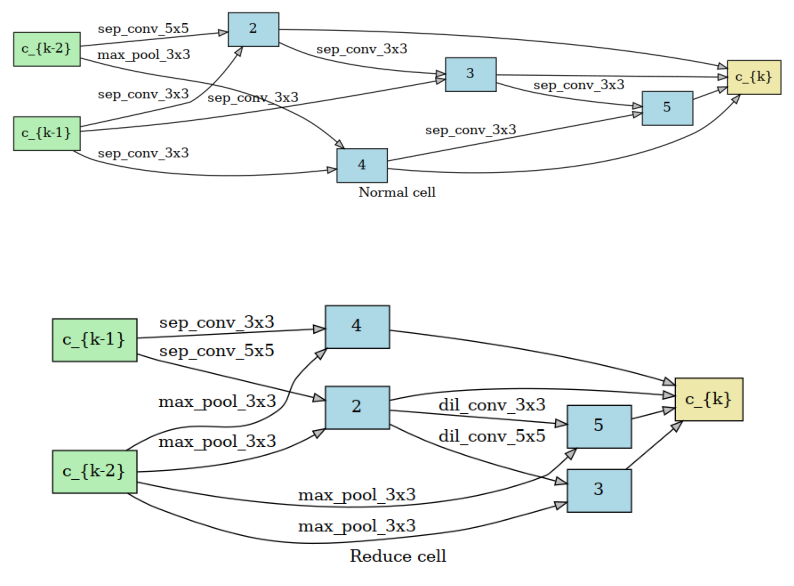

In [26]:
import io
import graphviz
import matplotlib.pyplot as plt
from PIL import Image

def plot_single_cell(arch_dict, cell_name):
    g = graphviz.Digraph(
        node_attr=dict(style='filled', shape='rect', align='center'),
        format='png'
    )
    g.body.extend(['rankdir=LR'])

    g.node('c_{k-2}', fillcolor='darkseagreen2')
    g.node('c_{k-1}', fillcolor='darkseagreen2')
    assert len(arch_dict) % 2 == 0

    for i in range(2, 6):
        g.node(str(i), fillcolor='lightblue')

    for i in range(2, 6):
        for j in range(2):
            op = arch_dict[f'{cell_name}/op_{i}_{j}']
            from_ = arch_dict[f'{cell_name}/input_{i}_{j}']
            if from_ == 0:
                u = 'c_{k-2}'
            elif from_ == 1:
                u = 'c_{k-1}'
            else:
                u = str(from_)
            v = str(i)
            g.edge(u, v, label=op, fillcolor='gray')

    g.node('c_{k}', fillcolor='palegoldenrod')
    for i in range(2, 6):
        g.edge(str(i), 'c_{k}', fillcolor='gray')

    g.attr(label=f'{cell_name.capitalize()} cell')

    image = Image.open(io.BytesIO(g.pipe()))
    return image

def plot_double_cells(arch_dict):
    image1 = plot_single_cell(arch_dict, 'normal')
    image2 = plot_single_cell(arch_dict, 'reduce')
    height_ratio = max(image1.size[1] / image1.size[0], image2.size[1] / image2.size[0])
    _, axs = plt.subplots(2, 1, figsize=(10, 20 * height_ratio))
    axs[0].imshow(image1)
    axs[1].imshow(image2)
    axs[0].axis('off')
    axs[1].axis('off')
    plt.show()

d = {}
for k, v in exported_arch.items():
    d[k] = v
    if isinstance(v, list):
        d[k] = v[0]
        if len(v) > 1:
            print(f"WARNING {v}")
        
plot_double_cells(d)

## Обучение с нуля найденной модели


То, что мы получили на последнем шаге - это всего лишь структура cells.
Чтобы получить готовую к использованию модель с заданными весами, нам нужно построить реальную модель на основе этой структуры, а затем полностью ее обучить.

Чтобы построить фиксированную модель на основе архитектурного dict, экспортированного из эксперимента,
мы можем использовать `nni.nas.space.model_context`. В with-context мы создадим фиксированную модель, основанную на `exported_arch`, вместо создания пространства.

In [17]:
from nni.nas.space import model_context

with model_context(exported_arch):
    final_model = DartsSpace(width=10, num_cells=8, dataset='cifar')

In [18]:
train_loader = DataLoader(train_data, batch_size=96, num_workers=6)  # Use the original training data

In [19]:
max_epochs = 100

evaluator = Classification(
    learning_rate=1e-3,
    weight_decay=1e-4,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
    max_epochs=max_epochs,
    accelerator='auto',
    export_onnx=False,          # Disable ONNX export for this experiment
    fast_dev_run=fast_dev_run,   # Should be false for fully training
    num_classes = 10
)

evaluator.fit(final_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | metrics   | ModuleDict       | 0     
2 | _model    | DARTS            | 144 K 
-----------------------------------------------
144 K     Trainable params
0         Non-trainable params
144 K     Total params
0.577     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[2024-10-10 22:35:08] Intermediate result: 0.5232999920845032  (Index 0)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:35:57] Intermediate result: 0.6236000061035156  (Index 1)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:36:47] Intermediate result: 0.6937999725341797  (Index 2)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:37:37] Intermediate result: 0.7269999980926514  (Index 3)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:38:27] Intermediate result: 0.7458000183105469  (Index 4)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:39:17] Intermediate result: 0.7657999992370605  (Index 5)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:40:07] Intermediate result: 0.7843000292778015  (Index 6)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:40:57] Intermediate result: 0.7943999767303467  (Index 7)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:41:47] Intermediate result: 0.788100004196167  (Index 8)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:42:37] Intermediate result: 0.7996000051498413  (Index 9)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:43:27] Intermediate result: 0.8029000163078308  (Index 10)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:44:17] Intermediate result: 0.8149999976158142  (Index 11)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:45:06] Intermediate result: 0.8151000142097473  (Index 12)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:45:56] Intermediate result: 0.8184000253677368  (Index 13)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:46:46] Intermediate result: 0.8072999715805054  (Index 14)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:47:36] Intermediate result: 0.8230000138282776  (Index 15)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:48:26] Intermediate result: 0.8375999927520752  (Index 16)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:49:16] Intermediate result: 0.8374999761581421  (Index 17)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:50:05] Intermediate result: 0.833899974822998  (Index 18)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:50:55] Intermediate result: 0.8320000171661377  (Index 19)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:51:44] Intermediate result: 0.8384000062942505  (Index 20)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:52:34] Intermediate result: 0.8414000272750854  (Index 21)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:53:24] Intermediate result: 0.8464000225067139  (Index 22)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:54:13] Intermediate result: 0.8458999991416931  (Index 23)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:55:03] Intermediate result: 0.8503999710083008  (Index 24)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:55:52] Intermediate result: 0.8400999903678894  (Index 25)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:56:43] Intermediate result: 0.8497999906539917  (Index 26)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:57:32] Intermediate result: 0.8439000248908997  (Index 27)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:58:22] Intermediate result: 0.8389000296592712  (Index 28)


Validation: 0it [00:00, ?it/s]

[2024-10-10 22:59:12] Intermediate result: 0.8560000061988831  (Index 29)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:00:02] Intermediate result: 0.8438000082969666  (Index 30)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:00:51] Intermediate result: 0.8575999736785889  (Index 31)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:01:41] Intermediate result: 0.854200005531311  (Index 32)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:02:31] Intermediate result: 0.8553000092506409  (Index 33)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:03:20] Intermediate result: 0.8529999852180481  (Index 34)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:04:10] Intermediate result: 0.8561999797821045  (Index 35)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:05:00] Intermediate result: 0.8479999899864197  (Index 36)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:05:49] Intermediate result: 0.8468999862670898  (Index 37)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:06:39] Intermediate result: 0.8572999835014343  (Index 38)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:07:28] Intermediate result: 0.8540999889373779  (Index 39)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:08:18] Intermediate result: 0.8553000092506409  (Index 40)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:09:07] Intermediate result: 0.8644000291824341  (Index 41)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:09:57] Intermediate result: 0.8615999817848206  (Index 42)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:10:47] Intermediate result: 0.8682000041007996  (Index 43)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:11:36] Intermediate result: 0.8618000149726868  (Index 44)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:12:26] Intermediate result: 0.8618000149726868  (Index 45)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:13:16] Intermediate result: 0.862500011920929  (Index 46)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:14:06] Intermediate result: 0.8640000224113464  (Index 47)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:14:56] Intermediate result: 0.8629999756813049  (Index 48)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:15:45] Intermediate result: 0.8543999791145325  (Index 49)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:16:35] Intermediate result: 0.8669999837875366  (Index 50)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:17:24] Intermediate result: 0.8632000088691711  (Index 51)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:18:14] Intermediate result: 0.866100013256073  (Index 52)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:19:03] Intermediate result: 0.8705000281333923  (Index 53)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:19:53] Intermediate result: 0.8669999837875366  (Index 54)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:20:45] Intermediate result: 0.8647000193595886  (Index 55)


Validation: 0it [00:00, ?it/s]

[2024-10-10 23:21:36] Intermediate result: 0.867900013923645  (Index 56)
[2024-10-10 23:21:48] WARNING: Trainer status is detected to be interrupted.


/home/alexandr/miniconda3/envs/ml/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


KeyboardInterrupt: Trainer status is detected to be interrupted.

# QLoRA

In [1]:
# !pip install torchao -q
# !pip install torchtune -q

In [2]:

import gc

import torch
from torchtune.modules.peft import LoRALinear

/home/alexandr/miniconda3/envs/ml/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
def print_cuda_memory_allocated():
    memory = torch.cuda.memory_allocated()
    print(f"Memory allocated {memory} bytes / {memory / 1024 / 1024:0.3f} MB")
    print()

def empty_cuda_cache():
    torch.cuda.empty_cache()
    gc.collect()


In [5]:
torch.set_default_device("cuda")

## Использование QLoRA для сохранения памяти


В этом разделе мы рассмотрим, как применить QLoRA из torchtune. Для более подробного ознакомления с QLoRA в `torchtune` и базовыми абстракциями, пожалуйста, ознакомьтесь с разделом [QLoRA в torchtune deepdive](https://pytorch.org/torchtune/stable/tutorials/qlora_finetune.html#qlora-deepdive-label).

Основной идеей QLoRA является различие между вычислительными типами данных и типами данных для хранения (dtypes). В частности, QLoRA сохраняет параметры базовой модели с точностью до 4 бит (т.е. dtype хранилища) и выполняет вычисления с исходной более высокой точностью (dtype вычисления), обычно либо fp32, либо bf16. В качестве первого шага QLoRA необходимо квантовать эти параметры базовой модели с точностью до 4 бит и сохранить их.

Вот пример создания квантованного лоралинейного слоя в сравнении с неквантованным лоралинейным слоем. Как мы можем видеть, квантованный слой потребляет в 8 раз меньше памяти, чем его неквантованный аналог.

In [6]:
qlora_linear = LoRALinear(512, 512, rank=8, alpha=0.1, quantize_base=True)
print_cuda_memory_allocated()

for p in qlora_linear.parameters():
    print(type(p.data))
    break

Memory allocated 169472 bytes / 0.162 MB

<class 'torchao.dtypes.nf4tensor.NF4Tensor'>


In [7]:
del qlora_linear
empty_cuda_cache()

In [8]:
lora_linear = LoRALinear(512, 512, rank=8, alpha=0.1, quantize_base=False)
print_cuda_memory_allocated()

for p in lora_linear.parameters():
    print(type(p.data))
    break

Memory allocated 1218048 bytes / 1.162 MB

<class 'torch.Tensor'>


In [9]:
del lora_linear
empty_cuda_cache()

## Применение QLoRA

Теперь мы рассмотрим, как вы можете инициализировать модель Llama2-7b с поддержкой QLoRA, а также некоторые детали, связанные с установкой чекпоинтинтов с помощью QLoRA.

С помощью `torchtune` вы можете использовать простой конструктор, аналогичный конструктору LoRa (lora_llama_2_7b), чтобы применить QLoRA к моделям Llama2. Вот простой пример инициализации модели Llama2-7b с QLoRA:

In [10]:
from torchtune.models.llama2 import qlora_llama2_7b

In [11]:
qlora_model = qlora_llama2_7b(lora_attn_modules=["q_proj"])
print_cuda_memory_allocated()

Memory allocated 4488200192 bytes / 4280.281 MB



In [12]:
del qlora_model
empty_cuda_cache()

Возникает вопрос, как сильно отличается память в случае QLoRA и LoRA для не большой LLM как llama2 с 7B параметрами.

In [13]:
from torchtune.models.llama2 import lora_llama2_7b

In [14]:
lora_model = lora_llama2_7b(lora_attn_modules=["q_proj"])
print_cuda_memory_allocated()

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 

упс... Нам даже не хватит 6GB видеопамяти без квантизаций

К сожалению, мы не сможем работать с весами моделей из сеймейства LLAMA, так как нам не дадут доступ для русских аккаунтов...

Поэтому мы попробуем Qwen2 и версию 0.5b (у нас нет под рукой лишней V100 или хотя бы RTX4090)

In [13]:
from torchtune.models.qwen2 import lora_qwen2_0_5b

In [14]:
lora_model = lora_qwen2_0_5b(lora_attn_modules=["q_proj", "v_proj"], use_dora=False, quantize_base=False)
print_cuda_memory_allocated()

Memory allocated 2384039424 bytes / 2273.597 MB



In [15]:
del lora_model
empty_cuda_cache()

In [16]:
print_cuda_memory_allocated()

Memory allocated 1048576 bytes / 1.000 MB



### Загрузка предобученной модели

Первым шагом в любой работе с finetuning является загрузка предварительно обученной базовой модели. torchtune поддерживает интеграцию с Hugging Face Hub -- коллекцией новейших и лучших весов моделей.


In [17]:
# Вы уверены что хотите запустить???

# !tune download Qwen/Qwen2-0.5B-Instruct --output-dir /tmp/Qwen2-0.5B-Instruct --ignore-patterns None

## Определение конфига

Очень важным является конфиг (рецепт) для finetuning. В учебных целях мы воспользуемся готовым конфигом, предложенным в библиотеке `torchtune`. 


Все конфиги для семейства моделей Qwen2 можно найти на [github](https://github.com/pytorch/torchtune/tree/5de500147e57d4d35e296faba68b296c03a1a2a0/recipes/configs/qwen2).


Мы воспользуемся [конфигом](https://github.com/pytorch/torchtune/blob/5de500147e57d4d35e296faba68b296c03a1a2a0/recipes/configs/qwen2/0.5B_lora_single_device.yaml) `qwen2/0.5B_lora_single_device`, так как будем учить на одной GPU.

[Подробнее про написание своих конфигов](https://pytorch.org/torchtune/stable/deep_dives/configs.html#config-tutorial-label)

Посмотреть все доступные конфиги можно с помощью следующей команды

In [18]:
!tune ls

/home/alexandr/miniconda3/envs/ml/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
RECIPE                                   CONFIG                                  
full_finetune_single_device              llama2/7B_full_low_memory               
                                         code_llama2/7B_full_low_memory          
                                         llama3/8B_full_single_device            
                                         llama3_1/8B_full_single_device          
                                         llama3_2/1B_full_single_device          
                                         llama3_2/3B_full_single_device          
                                         mistral/7B_full_low_memory              
                                         phi3/mini_full_low_memory           

К счастью, благодаря хорошо прописанным конфигам, обучение можно написать в одну строчку, только при условии что у вас правильная версия `pytorch` и работает следующий `import`

In [1]:
import torch

In [2]:
print(torch.__version__)

2.4.0+cu121


In [3]:
from torch.distributed._composable.fsdp import CPUOffloadPolicy

In [5]:
!tune run lora_finetune_single_device --config qwen2/0.5B_lora_single_device

INFO:torchtune.utils._logging:Running LoRAFinetuneRecipeSingleDevice with resolved config:

batch_size: 4
checkpointer:
  _component_: torchtune.training.FullModelHFCheckpointer
  checkpoint_dir: /tmp/Qwen2-0.5B-Instruct
  checkpoint_files:
  - model.safetensors
  model_type: QWEN2
  output_dir: /tmp/Qwen2-0.5B-Instruct-lora-finetune
  recipe_checkpoint: null
compile: false
dataset:
  _component_: torchtune.datasets.alpaca_cleaned_dataset
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: false
epochs: 1
gradient_accumulation_steps: 4
log_every_n_steps: 1
log_peak_memory_stats: false
loss:
  _component_: torchtune.modules.loss.CEWithChunkedOutputLoss
lr_scheduler:
  _component_: torchtune.modules.get_cosine_schedule_with_warmup
  num_warmup_steps: 100
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_logging.DiskLogger
  log_dir: /tmp/Qwen2-0.5B-Instruct-lora-finetune
model:
  _component_: torchtune.models.qwen2.